# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [28]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [64]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
batch_size=8
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [65]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


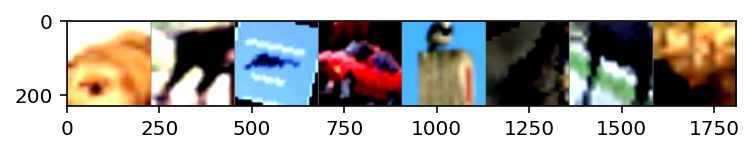

  dog  deer plane   car  bird  frog horse  deer


In [85]:
# Explore data
## YOUR CODE HERE ##
# inspired from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images (in this case the first batch)
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels according to the grid
grid_sizes=batch_size
if batch_size>8:
    grid_sizes=int(np.sqrt(batch_size))
pos=range(0, batch_size, grid_sizes)

for i in pos:
    print(' '.join('%5s' % classes[labels[j]] for j in range(i,i+grid_sizes)))

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [67]:
## YOUR CODE HERE ##
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        #x = x.view(x.shape[0], -1) # for torch 0.4.0
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        
        return x


net = Classifier()


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [68]:
## YOUR CODE HERE ##
import torch.optim as optim
#The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [70]:
## YOUR CODE HERE ##

# move into a cuda-enabled device
# device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
# # Assuming that we are on a CUDA machine, this should print a CUDA device:
# print(device)
# net.to(device)

epochs = 30

train_losses, test_losses = [], []
train_accs, test_accs = [], []
epoch_list = range(epochs)

for e in epoch_list:
    
    tot_train_loss = 0
    train_correct = 0
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        #images, labels = images.to(device), labels.to(device)
        images, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        log_ps = net(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
     
        tot_train_loss += loss.item()
    
        # compute train data accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_correct += equals.sum().item()
       
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                #images, labels = images.to(device), labels.to(device)

                log_ps = net(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_correct / len(trainloader.dataset))
        test_accs.append(test_correct / len(testloader.dataset))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Train Accuracy: {:.3f}".format(train_correct / len(trainloader.dataset)),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))


Epoch: 1/30..  Training Loss: 0.231..  Test Loss: 0.197..  Train Accuracy: 0.313 Test Accuracy: 0.427
Epoch: 2/30..  Training Loss: 0.186..  Test Loss: 0.174..  Train Accuracy: 0.461 Test Accuracy: 0.492
Epoch: 3/30..  Training Loss: 0.171..  Test Loss: 0.164..  Train Accuracy: 0.507 Test Accuracy: 0.517
Epoch: 4/30..  Training Loss: 0.161..  Test Loss: 0.161..  Train Accuracy: 0.542 Test Accuracy: 0.542
Epoch: 5/30..  Training Loss: 0.155..  Test Loss: 0.155..  Train Accuracy: 0.563 Test Accuracy: 0.564
Epoch: 6/30..  Training Loss: 0.149..  Test Loss: 0.150..  Train Accuracy: 0.580 Test Accuracy: 0.578
Epoch: 7/30..  Training Loss: 0.144..  Test Loss: 0.151..  Train Accuracy: 0.592 Test Accuracy: 0.571
Epoch: 8/30..  Training Loss: 0.140..  Test Loss: 0.148..  Train Accuracy: 0.606 Test Accuracy: 0.587
Epoch: 9/30..  Training Loss: 0.137..  Test Loss: 0.150..  Train Accuracy: 0.616 Test Accuracy: 0.584
Epoch: 10/30..  Training Loss: 0.133..  Test Loss: 0.143..  Train Accuracy: 0.627 

Plot the training loss (and validation loss/accuracy, if recorded).

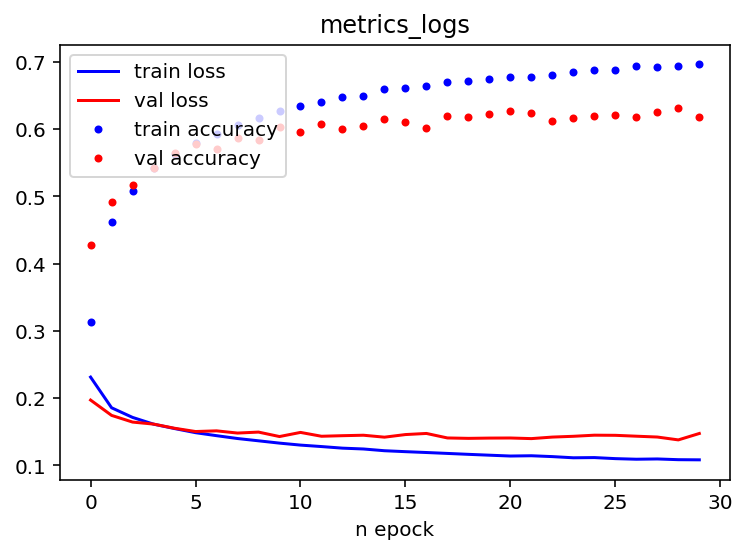

In [71]:
## YOUR CODE HERE ##

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

def draw_metric_logs(lst_iter, train_loss, train_acc, test_loss, test_acc, title):
    plt.plot(lst_iter, train_loss, '-b', label='train loss')
    plt.plot(lst_iter, test_loss, '-r', label='val loss')
    plt.plot(lst_iter, train_acc, '.b', label='train accuracy')
    plt.plot(lst_iter, test_acc, '.r', label='val accuracy')

    plt.xlabel("n epock")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method

    # show
    plt.show()
    
title = 'metrics_logs'    
    
draw_metric_logs(epoch_list, train_losses, train_accs, test_losses, test_accs, title)

In [89]:
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
batch_size=16
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

#Freeze parameters so we don't backprop through them
model = torchvision.models.densenet121(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 10))
                          ]))
    
model.classifier =  classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
model.to(device);

start = time.time()
# move into a cuda-enabled device
# device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
# # Assuming that we are on a CUDA machine, this should print a CUDA device:
# print(device)
# net.to(device)

epochs = 1

train_losses, test_losses = [], []
train_accs, test_accs = [], []
epoch_list = range(epochs)

for e in epoch_list:
    
    tot_train_loss = 0
    train_correct = 0
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        #images, labels = images.to(device), labels.to(device)
        images, labels = data[0].to(device),data[1].to(device)
        
        # zero the parameter gradients
        optimizer2.zero_grad()
        
        # forward + backward + optimize
        log_ps = model.forward(images)
        loss = criterion2(log_ps, labels)
        loss.backward()
        optimizer2.step()
     
        tot_train_loss += loss.item()
    
        # compute train data accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_correct += equals.sum().item()
       
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                
                images, labels = images.to(device), labels.to(device)
                
                log_ps = model.forward(images)
                loss = criterion2(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_correct / len(trainloader.dataset))
        test_accs.append(test_correct / len(testloader.dataset))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Train Accuracy: {:.3f}".format(train_correct / len(trainloader.dataset)),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

finish = time.time()

print('epoch {} training time consumed: {:.2f}s'.format(epoch, finish - start))


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

correct = 0
total = 0

with torch.no_grad():
    
    for images, labels in testloader:
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
    
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.